<a href="https://www.kaggle.com/code/arnaud58/luminosity-classification-horse-racing?scriptVersionId=100267366" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span class="title-section w3-xxlarge" id="import">Importing library 📚</span>
<hr>

In [1]:
import sys
import os

from IPython import display
from PIL import Image
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet import *
from keras.applications.vgg19 import *
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

In [2]:
print("Python version :", sys.version, "\nTF version     :", tf.version.VERSION, "\nNumpy version  :", np.version.version, "\n")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU') 

Python version : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0] 
TF version     : 2.6.4 
Numpy version  : 1.21.6 

Num GPUs Available:  1


2022-07-07 14:41:31.392296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 14:41:31.496482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 14:41:31.497289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sns.set_style("whitegrid")
plt.style.use('seaborn-pastel') # seaborn-pastel seaborn-whitegrid

plt.rcParams.update({
    'backend': 'ps',
    'axes.labelsize': 15,
    'axes.labelweight' : 'bold',
    'legend.fontsize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    "font.sans-serif": ["Helvetica"],
    "font.serif": ["Palatino"],
    "font.family": "serif",
    'figure.figsize': [13,8],
})

In [4]:
pathDrive = '/kaggle/input/horse-racing-photo-finish/'
imageSize = 'smallUrl/'
path      = pathDrive +"horse-racing-final/" + imageSize

# <span class="title-section w3-xxlarge" id="prepare">Prepare Data 🪄</span>
<hr>

In [5]:
df = pd.read_csv(pathDrive+"photoFinish.csv", sep = ';')

DIURNE images :


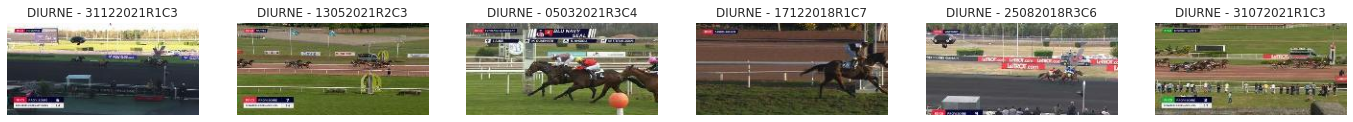

SEMINOCTURNE images :


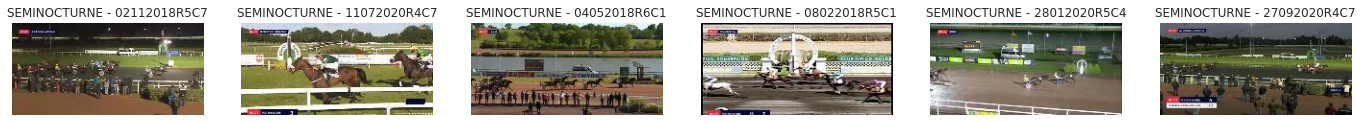

NOCTURNE images :


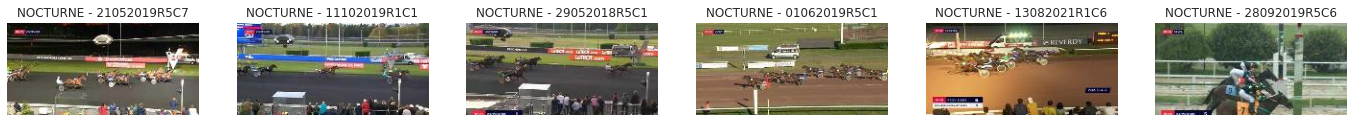

In [6]:
rows, cols = (1, 6)
cat = "luminosity"
classNames = ['DIURNE', 'SEMINOCTURNE', 'NOCTURNE']
allCategories = set(df[cat].to_numpy())

for category in classNames :
    print(f'{category} images :')
    
    categoryImages = df[df[cat] == category].to_numpy()
    
    fig = plt.figure(figsize = (24, 13))
    for i in range(rows * cols):
        imageFile = categoryImages[np.random.randint(0, len(categoryImages))][0]
        image = cv2.imread(path+imageFile)
        imageFile = imageFile[:-4]
        
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(image[:, :, ::-1])
        plt.title(f'{category} - {imageFile}')
        plt.axis('off')
        
    plt.show()

In [7]:
%%time
# Create input data
x0 = df.pictureName.to_numpy()
x = []

for name in x0 :
    image = cv2.imread(path+name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (200, 96)) 
    
    x.append(image)
    
# xOld = x # use for debug
x = np.array(x)

CPU times: user 13.4 s, sys: 5.57 s, total: 19 s
Wall time: 3min 46s


In [8]:
# Create output data
lb = LabelBinarizer()
lb.fit(classNames)
y = lb.transform(df.luminosity)

In [9]:
trainLen = 24750 # Number of race from the 1st january 2018 to the 31th december 2020
valLen   = 1000  # validation data lenght
# Split between train and test datas
trainX, trainY = x[:trainLen-valLen], y[:trainLen-valLen]
valX  , valY   = x[trainLen-valLen:trainLen], y[trainLen-valLen:trainLen]
testX , testY  = x[trainLen:], y[trainLen:]

In [10]:
# Normalize data
# trainX = trainX.astype('float32') / 255
# valX   = valX.astype('float32')   / 255
# testX  = testX.astype('float32')  / 255

In [11]:
print("trainX shape :", trainX.shape)
print("trainY shape :", trainY.shape)
print("valX shape :", valX.shape)
print("valY.shape :", valY.shape)
print("testX shape :", testX.shape)
print("testY.shape :", testY.shape)

trainX shape : (23750, 96, 200, 3)
trainY shape : (23750, 3)
valX shape : (1000, 96, 200, 3)
valY.shape : (1000, 3)
testX shape : (11174, 96, 200, 3)
testY.shape : (11174, 3)


# <span class="title-section w3-xxlarge" id="build">Train Model 🛠️</span>
<hr>

## <span class="title-section w3-xlarge" id="build">Model Functions ⚙️</span>
<hr>

In [12]:
epochs = 200 # Number of epochs to train for.
batch_size = 50 # Batch size for training.
history_metrics = [Precision(name="precision"), Recall(name="recall"), "accuracy"]
history_metricsName = ["precision", "recall", "accuracy"]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

2022-07-07 14:45:20.525284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 14:45:20.525872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 14:45:20.526939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 14:45:20.527689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
model = VGG19(
    weights=None,
    include_top=True,
    classifier_activation="softmax",
    input_shape=trainX[0].shape, 
    classes = len(trainY[0])
)

In [14]:
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate = 0.0005), loss='binary_crossentropy', metrics=history_metrics)

## <span class="title-section w3-xlarge" id="build">Model Fit 🧮</span>
<hr>

In [15]:
%%time
history = model.fit(trainX, trainY,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(valX, valY),
          callbacks=[callback])

2022-07-07 14:45:23.238648: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1368000000 exceeds 10% of free system memory.
2022-07-07 14:45:24.616533: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1368000000 exceeds 10% of free system memory.
2022-07-07 14:45:25.628025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-07-07 14:45:27.527079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


475/475 [==============================] - 95s 179ms/step - loss: 0.4893 - precision: 0.6505 - recall: 0.6265 - accuracy: 0.6435 - val_loss: 0.5411 - val_precision: 0.5910 - val_recall: 0.5880 - val_accuracy: 0.5890
Epoch 2/200
475/475 [==============================] - 84s 178ms/step - loss: 0.4702 - precision: 0.6674 - recall: 0.6479 - accuracy: 0.6582 - val_loss: 0.5405 - val_precision: 0.5921 - val_recall: 0.5880 - val_accuracy: 0.5890
Epoch 3/200
475/475 [==============================] - 84s 178ms/step - loss: 0.4603 - precision: 0.6796 - recall: 0.6529 - accuracy: 0.6701 - val_loss: 0.5305 - val_precision: 0.5939 - val_recall: 0.5850 - val_accuracy: 0.5910
Epoch 4/200
475/475 [==============================] - 84s 178ms/step - loss: 0.4529 - precision: 0.6844 - recall: 0.6591 - accuracy: 0.6759 - val_loss: 0.5247 - val_precision: 0.5992 - val_recall: 0.5890 - val_accuracy: 0.5930
Epoch 5/200
475/475 [==============================] - 84s 178ms/step - loss: 0.4469 - precision: 0.

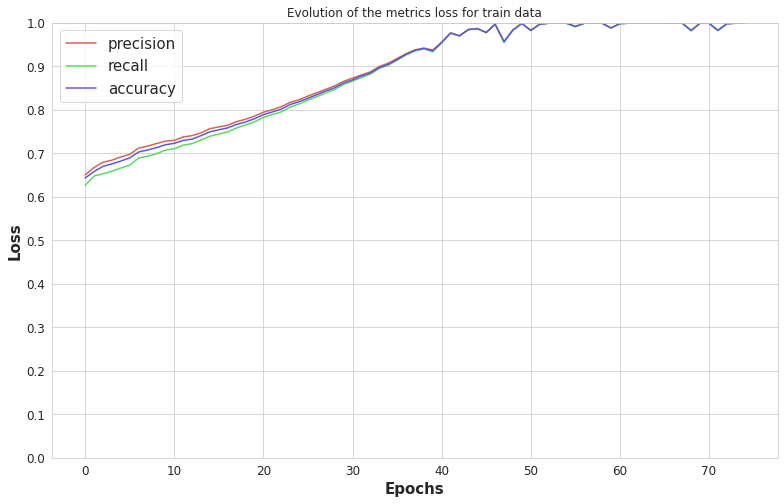

In [16]:
beginPlot = 0

for i in range(len(history_metrics)) :
    his = history.history[history_metricsName[i]]
    plt.plot(range(beginPlot,len(his)), his[beginPlot:], label = history_metricsName[i], color = sns.color_palette("hls", len(history_metrics))[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Evolution of the metrics loss for train data")
plt.ylim((0,1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend()
plt.show()

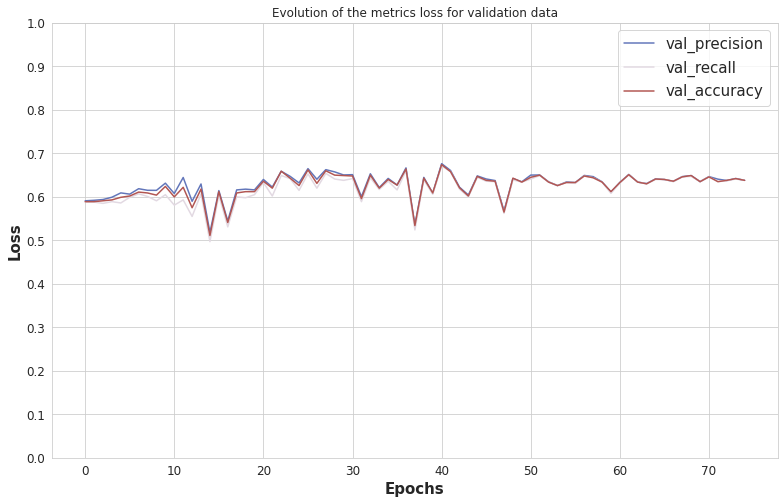

In [17]:
for i in range(len(history_metrics)) :
    his = history.history["val_"+history_metricsName[i]]
    plt.plot(range(beginPlot,len(his)), his[beginPlot:], label = "val_"+history_metricsName[i], color = sns.color_palette("twilight_shifted", len(history_metrics))[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolution of the metrics loss for validation data")
plt.ylim((0,1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend()
plt.show()

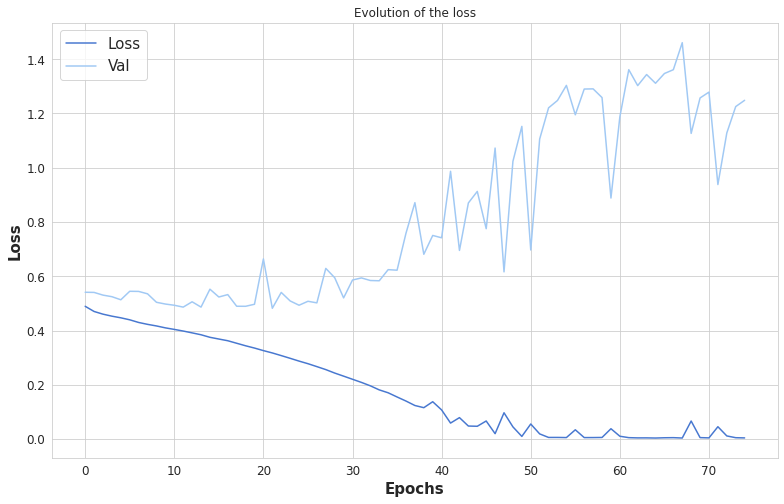

In [18]:
plt.plot(range(beginPlot,len(history.history['loss'])), history.history['loss'][beginPlot:], label = 'Loss', color = sns.color_palette("muted",10)[0])
plt.plot(range(beginPlot,len(history.history['val_loss'])), history.history['val_loss'][beginPlot:], label = 'Val', color = sns.color_palette("pastel",10)[0])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Evolution of the loss")
plt.legend()
plt.show()

In [19]:
model.save(f'VGG19-{cat}.h5')

# <span class="title-section w3-xxlarge" id="plot">Plot Values 📊</span>
<hr>

In [20]:
%%time
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss : ', scores[0])
print('Test accuracy : ', scores[1])

2022-07-07 16:32:17.809873: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 643622400 exceeds 10% of free system memory.
2022-07-07 16:32:18.112625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 643622400 exceeds 10% of free system memory.


350/350 [==============================] - 14s 36ms/step - loss: 0.9889 - precision: 0.7141 - recall: 0.7130 - accuracy: 0.7135
Test loss :  0.9888826012611389
Test accuracy :  0.7140808701515198
CPU times: user 6.38 s, sys: 642 ms, total: 7.02 s
Wall time: 15.1 s


In [21]:
%%time
predY = model.predict(testX)             # Vector of probabilities
predLabels = np.argmax(predY, axis = 1)  # We take the highest probability
trueLabels = np.argmax(testY, axis = 1)  # Vector of truth labels

2022-07-07 16:32:37.986769: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 643622400 exceeds 10% of free system memory.


CPU times: user 2.63 s, sys: 1.06 s, total: 3.69 s
Wall time: 21.8 s


In [22]:
%%time
cm = confusion_matrix(trueLabels, predLabels)
cr = classification_report(trueLabels, predLabels, target_names=classNames, output_dict=True)
df_cm = pd.DataFrame(cm)
df_cr = pd.DataFrame(cr)

print(f'Confusion matrix: \n')
display.display(df_cm)
print(f'Classification report: \n')
display.display(df_cr)

Confusion matrix: 



,0,1,2
0,5854,99,1352
1,109,92,90
2,1312,239,2027


Classification report: 



,DIURNE,SEMINOCTURNE,NOCTURNE,accuracy,macro avg,weighted avg
precision,0.804674,0.213953,0.584318,0.713531,0.534315,0.718730
recall,0.801369,0.316151,0.566518,0.713531,0.561346,0.713531
f1-score,0.803018,0.255201,0.575280,0.713531,0.544500,0.715828
support,7305.000000,291.000000,3578.000000,0.713531,11174.000000,11174.000000


CPU times: user 33.8 ms, sys: 0 ns, total: 33.8 ms
Wall time: 36.6 ms


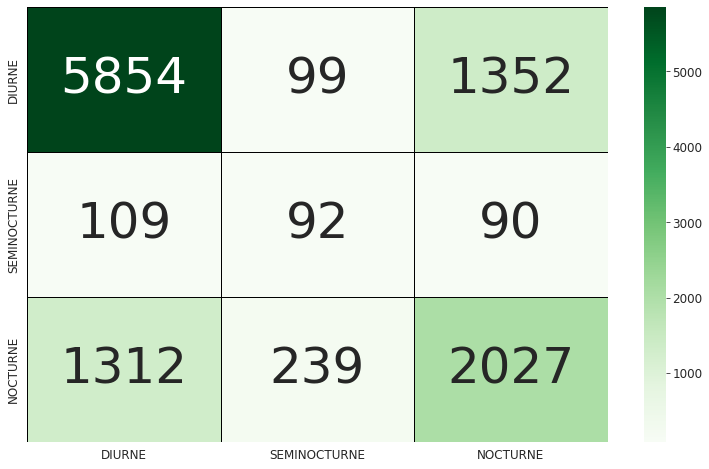

In [23]:
# visualize with seaborn library
sns.heatmap(cm, annot=True, cmap=plt.cm.Greens, linewidths=1, linecolor="k", fmt="d", annot_kws={"size": 50}, xticklabels=classNames, yticklabels=classNames) 
plt.show()

DIURNE images :


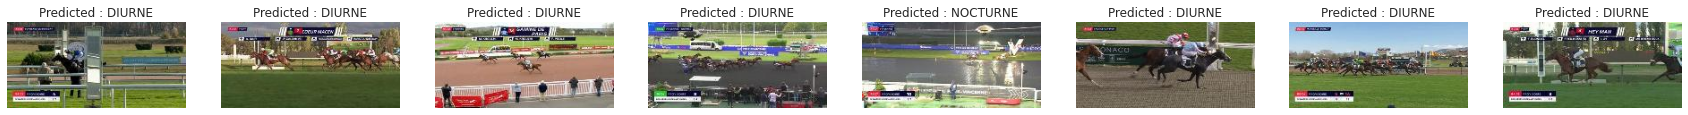

SEMINOCTURNE images :


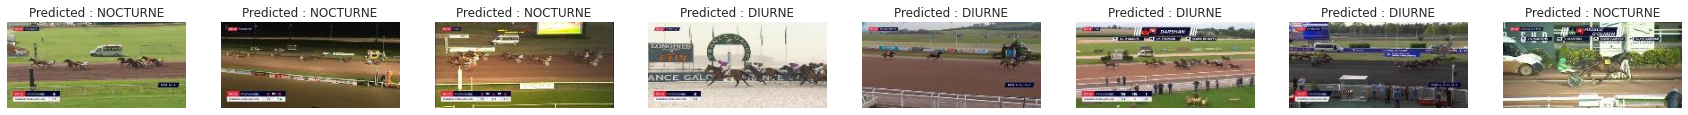

NOCTURNE images :


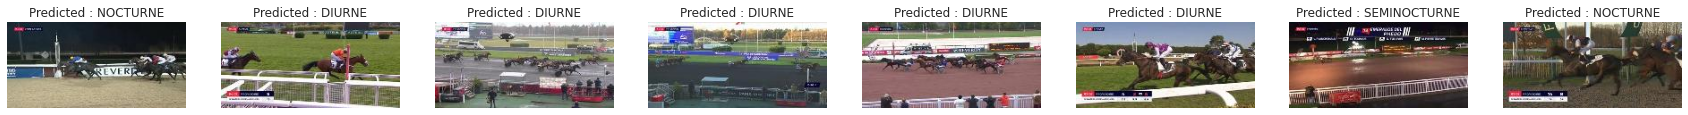

In [24]:
rows, cols = (1, 8)
for category in classNames :
    print(f'{category} images :')
    
    categoryImages = df[df[cat] == category].to_numpy()
    
    fig = plt.figure(figsize = (30, 20))
    for i in range(rows * cols):
        index = np.random.randint(len(testX))

        fig.add_subplot(rows, cols, i+1)
        plt.imshow(testX[index])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title(f'Predicted : ' + classNames[predLabels[index]])
        plt.axis('off')
        
    plt.show()